# Диффузионная модель для генерации изображений цветов
В данном ноутбке используется модель DDPM из репозитория https://github.com/cloneofsimo/minDiffusion , прочитать про неё и изучить статьи в references можно по [данной ссылке](https://keras.io/examples/generative/ddpm/). 

Ноутбук запускался на google colabolatory, потому часть кода с клонированием репозитория и выгрузке датасета может быть опущена при локальном запуске (все нужные файлы нужно просто добавить в текущий путь или PATH)

In [1]:
# ONLY FOR COLAB

# clone repo with ddpm model

!git clone https://github.com/cloneofsimo/minDiffusion.git

Клонирование в «minDiffusion»...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 342 (delta 47), reused 332 (delta 44), pack-reused 0
Получение объектов: 100% (342/342), 3.59 МиБ | 7.14 МиБ/с, готово.
Определение изменений: 100% (47/47), готово.


Далее загрузим датасет и считаем файл с метками ветов (по дефолту он в формате MATLAB-а)

In [2]:
# ONLY FOR COLAB

#load data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import scipy.io
mat = scipy.io.loadmat('/content/gdrive/MyDrive/Diffusion_model/102flowers/imagelabels.mat')
LABELS = mat['labels'][0]

## Часть 1. Отбор изображений
Тут мы воспользуемся тем, то в задании позволено исопльзовать лишь часть датасета и отберем только те классы цветов, число фотографий в датасете которых превышает пороговое значение 
(здесь взято 160)

In [4]:
import numpy as np

unique, counts = np.unique(LABELS, return_counts=True)
mask = counts > 160
labels_selected = unique[mask]
print(labels_selected)

[46 51 73 74 77 81 89 94]


## Часть 2. Модули и датасет

In [5]:
# all required modules

from typing import Dict, Optional, Tuple
import os
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from minDiffusion.mindiffusion.unet import NaiveUnet
from minDiffusion.mindiffusion.ddpm import DDPM
from PIL import Image

FLOWERS_PATH = "/content/gdrive/MyDrive/Diffusion_model/102flowers/jpg"

Для того чтобы грамотно обрабатывать метки классов изображений был написан кастомный класс для датасета (споосба проще, увы, не нашел)

In [6]:
from torchvision.io import read_image


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'image_{:05d}.jpg'.format(idx+1))
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Часть 3. Предобработка и train loop

*Предобработка изображений*
включает в себя :
- resize к размеру 64 x 64 пикселя (работает только с PIL)
- Нормировку изображений по среднему и дисперсии (работает только с тезнорами)

Уникальная часть кода выделена комменатриями

Далее производится обучение модели и каждые 10 эпох результат генерации записывается в папку /contetns 

*Важно* ! При обучении моделии объязательно учитываем классификацию цветов, чтобы де-факто на каждый класс создавалась своя модель

In [7]:
def train_flowers(
    n_epoch: int = 451, device: str = None, load_pth: Optional[str] = None
) -> None:

    if device == None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=64), betas=(1e-4, 0.02), n_T=1000)

    if load_pth is not None:
        ddpm.load_state_dict(torch.load("ddpm_flowers.pth"))

    ddpm.to(device)

    # ---------------------------------------------------
    # BEGINING OF NEW CODE SEGMENT
    # ---------------------------------------------------

    # transformations
    tf = transforms.Compose(  # resize to 64 x 64, convert to tensor, normalize
        [
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # load dataset
    dataset = CustomImageDataset(FLOWERS_PATH, LABELS, transform=tf)

    # use only previously sleceted labels
    inds = np.arange(len(LABELS))[np.isin(LABELS, labels_selected)]
    dataset = Subset(dataset, inds)

    # ---------------------------------------------------
    # END OF NEW CODE SEGMENT
    # ---------------------------------------------------

    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)
    optim = torch.optim.Adam(ddpm.parameters(), lr=2e-5)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()

        # save every 10-th epoch
        if i % 10 == 0:
          with torch.no_grad():
              xh = ddpm.sample(8, (3, 64, 64), device)
              xset = torch.cat([xh, x[:8]], dim=0)
              grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
              save_image(grid, f"./contents/ddpm_sample_flowers{i:03d}.png")

              # save model
              torch.save(ddpm.state_dict(), f"./ddpm_flowers.pth")

Обучим модель на (по умолчанию) 450 эпохах
Перед коммитом в репозиторий выход ячейки был скрыт в целях повышения читабельности ноутбука. Достигнутый в ходе оубчения loss составил 0.0339

In [ ]:
train_flowers()

# Часть 4. Результат
Приведем результат генерации (см. первые 8 картинок на диаграмме) и реальные изображения в качестве референса (нижние 8 картинок).

Видно, что модель способна генерировать что-то отдаленно похожее на реальное изображение цветов, но все еще далека до идеала. 

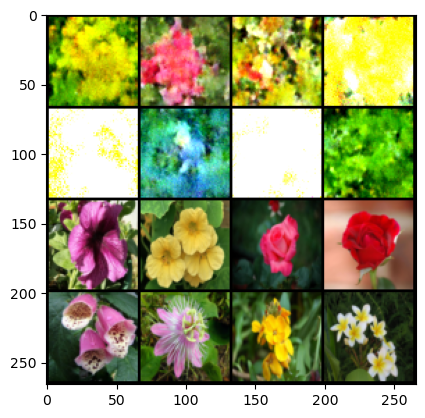

In [16]:
# plot example
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('./contents/ddpm_sample_flowers450.png')
imgplot = plt.imshow(img)
plt.show()

### Предложения по улучшению

Наличие в датасете цветков на темном фоне откровенно портит обучение и даже можно видеть результаты ошибочной генерации изображений с темном фоном (на сохраненных с эпох картинок).

*Как улучшить* : возможно, применить сегментацию формы цветка на изображении (в искомом датасете это присутсвует) и закрасить фон сплошным зеленым цветом, а может быть учить две разные модели на фон и на форму цветка (хотя тут возникает проблема согласования изображений)

Но вообще ddpm кажется не очень способной моделью и вероятно пытаться получить совсем хороший результат здесь не стоит